In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime
import lightgbm as lgb
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
import json
import os
from pandas.io.json import json_normalize
import datetime



In [2]:
# Reading the events and guests files from CSV
events_Fathers_Day_df = pd.read_csv('events_Fathers_Day.csv')
guests_host_Fathers_Day_df = pd.read_csv('guests_host_Fathers_Day.csv')

In [3]:
# design a new feature of guests who turned into hosts.
# first: in the events df, for each host find the first date when they hosted an event
# second: in the guests df, for each user find the first date when they attended an event
# third: merge these two tables based on the user_id. you'll get a table with three columns:
# user_id, as_host_date, all_events_date
# in the resulting table, keep only the users for whom the as_host_date is later (more than) all_events_date
# this will give a list of the guests who later became hosts

# "hosts_with_earliest_event_date_df" contains id of each host with the earliest date they hosted an event
temp = events_Fathers_Day_df[['event_date','host_id']]
hosts_with_earliest_event_date_df = temp.groupby('host_id', as_index=False).agg(min).rename(columns={'host_id': 'user_id','event_date': 'as_host_date'})

# "all_users_with_earliest_event_date_df" will contain information of users with an earliest even they attended, including as a guest
temp = guests_host_Fathers_Day_df[['event_date','user_id']]
all_users_with_earliest_event_date_df = temp.groupby('user_id', as_index=False).agg(min).rename(columns={'event_date': 'all_events_date'})

merged_data = pd.merge(hosts_with_earliest_event_date_df, all_users_with_earliest_event_date_df,\
         on = 'user_id')
#merged_data.head()

merged_data['guest2host'] = (merged_data['as_host_date'] > merged_data['all_events_date']).astype(int)
merged_data = merged_data.rename(columns={'user_id': 'host_id'})

guest_turned_host = merged_data['guest2host'].astype(int)
# by running merged_data['guest2host'].sum() you get the number of guests who turned into hosts as 198.

In [4]:
# merge the table with guests who turned into hosts in events_Fathers_Day_df to get a guest2host feature.

events_Fathers_Day_df = pd.merge(events_Fathers_Day_df,merged_data[['host_id','guest2host']],on = 'host_id')
events_Fathers_Day_df.head()

,event_id,host_id,event_type,event_category,correspondence,event_category_group,seasonal,event_date,sent_on,created_date,location,zip,premium_vs_free,template_name,guests,rsvp_yes,rsvp_no,rsvp_maybe,rsvp_undecided,search_term,guest2host
0,0014af9fc2d6ac3b8ac66fb441102eac,9e05f75c7816adef22d96f3ad57550fb,fathers_day,Fathers Day,f,Fathers Day,t,2016-06-19 22:00:00,2016-06-17 17:14:04,2016-06-16 23:35:20.42128,Unidentified,NaN,Free,bowtie,4,1,0,0,3,NaN,0
1,000e7310f690ecdd5a5e5dc4e339a418,62c38755966cdf525d6b47f0e16138a2,fathers_day,Fathers Day,f,Fathers Day,t,2016-06-17 08:00:00,2016-06-06 23:43:22,2016-06-03 23:58:29.99778,Unidentified,NaN,Free,dounutmisstheparty,23,17,1,0,5,NaN,0
2,00851fa1695bfc259802769cc6b46ab0,5a8d7395fd81b1c308fd696671188dd6,fathers_day,Fathers Day,f,Fathers Day,t,2016-06-16 08:30:00,2016-05-20 03:21:54.29749,2016-05-19 06:29:09.40654,Educational Institutions,NaN,Free,onecooldude,9,9,0,0,0,NaN,0
3,0096e736906d92b84cbaf3328e15b3f9,a311ded9c0c06b920b2da66909dfe645,fathers_day,Fathers Day,f,Fathers Day,t,2016-06-19 12:00:00,2016-05-31 22:46:48,2016-05-31 22:19:53.54265,Unidentified,NaN,Free,grillandchill,26,14,8,1,3,NaN,0
4,8857d843d65adc4aaf7b60d5e70425cf,a311ded9c0c06b920b2da66909dfe645,fathers_day,Fathers Day,f,Fathers Day,t,2018-06-17 12:00:00,2018-05-28 02:40:45,2018-05-28 02:11:26.88676,Unidentified,94947,Free,cst_shutterfly_fathersday18,33,17,9,2,5,NaN,0


In [5]:
# calculate the number of days between sent_on and event_date
events_Fathers_Day_df['event_vs_sent'] = (pd.to_datetime(events_Fathers_Day_df['event_date'])
                                               - pd.to_datetime(events_Fathers_Day_df['sent_on'])).astype('timedelta64[D]')


In [6]:
events_Fathers_Day_df.shape

(11267, 22)

In [7]:
temp = events_Fathers_Day_df[['event_id','host_id']].groupby('host_id', as_index=False).agg('count').rename(columns={'event_id': 'host_event_number'})
temp.head()

,host_id,host_event_number
0,0004920617bc4416de7fcc93f187a1bc,1
1,000e4510c297ee00b0e0c4eae8d45084,3
2,0014258b36591c855d080ab32d2bbf3b,1
3,0014f58538a0ed5dcc7102eb566c58ee,1
4,00237df8c5ba25db128a6ad2bf7b9765,1


In [8]:
temp = events_Fathers_Day_df[['event_id','host_id']].groupby('host_id', as_index=False).agg('count').rename(columns={'event_id': 'host_event_number'})
events_Fathers_Day_df = pd.merge(events_Fathers_Day_df,temp,on = 'host_id')
events_Fathers_Day_df.head()

,event_id,host_id,event_type,event_category,correspondence,event_category_group,seasonal,event_date,sent_on,created_date,location,zip,premium_vs_free,template_name,guests,rsvp_yes,rsvp_no,rsvp_maybe,rsvp_undecided,search_term,guest2host,event_vs_sent,host_event_number
0,0014af9fc2d6ac3b8ac66fb441102eac,9e05f75c7816adef22d96f3ad57550fb,fathers_day,Fathers Day,f,Fathers Day,t,2016-06-19 22:00:00,2016-06-17 17:14:04,2016-06-16 23:35:20.42128,Unidentified,NaN,Free,bowtie,4,1,0,0,3,NaN,0,2.0,1
1,000e7310f690ecdd5a5e5dc4e339a418,62c38755966cdf525d6b47f0e16138a2,fathers_day,Fathers Day,f,Fathers Day,t,2016-06-17 08:00:00,2016-06-06 23:43:22,2016-06-03 23:58:29.99778,Unidentified,NaN,Free,dounutmisstheparty,23,17,1,0,5,NaN,0,10.0,1
2,00851fa1695bfc259802769cc6b46ab0,5a8d7395fd81b1c308fd696671188dd6,fathers_day,Fathers Day,f,Fathers Day,t,2016-06-16 08:30:00,2016-05-20 03:21:54.29749,2016-05-19 06:29:09.40654,Educational Institutions,NaN,Free,onecooldude,9,9,0,0,0,NaN,0,27.0,1
3,0096e736906d92b84cbaf3328e15b3f9,a311ded9c0c06b920b2da66909dfe645,fathers_day,Fathers Day,f,Fathers Day,t,2016-06-19 12:00:00,2016-05-31 22:46:48,2016-05-31 22:19:53.54265,Unidentified,NaN,Free,grillandchill,26,14,8,1,3,NaN,0,18.0,3
4,8857d843d65adc4aaf7b60d5e70425cf,a311ded9c0c06b920b2da66909dfe645,fathers_day,Fathers Day,f,Fathers Day,t,2018-06-17 12:00:00,2018-05-28 02:40:45,2018-05-28 02:11:26.88676,Unidentified,94947,Free,cst_shutterfly_fathersday18,33,17,9,2,5,NaN,0,20.0,3


In [9]:
events_Fathers_Day_df['yes_vs_total'] = 1.0 * events_Fathers_Day_df['rsvp_yes']/events_Fathers_Day_df['guests']

In [10]:
cat_columns = ['event_type','correspondence','seasonal','zip']
num_columns = ['guests','yes_vs_total','event_vs_sent','host_event_number']
train_df = events_Fathers_Day_df[cat_columns+num_columns]
train_df.head()

,event_type,correspondence,seasonal,zip,guests,yes_vs_total,event_vs_sent,host_event_number
0,fathers_day,f,t,NaN,4,0.250000,2.0,1
1,fathers_day,f,t,NaN,23,0.739130,10.0,1
2,fathers_day,f,t,NaN,9,1.000000,27.0,1
3,fathers_day,f,t,NaN,26,0.538462,18.0,3
4,fathers_day,f,t,94947,33,0.515152,20.0,3


In [11]:
for c in cat_columns:
    train_df[c] = train_df[c].astype('category')

C:\Users\Leo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [12]:
# make sure that the numerical columns are float type
for col in num_columns:
    train_df[col] = train_df[col].astype(float)

print('done')

C:\Users\Leo\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


done


In [13]:
from sklearn.model_selection import train_test_split

X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(
    train_df[cat_columns + num_columns], events_Fathers_Day_df['guest2host'], test_size=0.33, random_state=42)

In [14]:
# Set fixed params
params_classification = {#"objective" : "regression",
        "metric" : "rmse",
        'max_depth' : -1,
        'max_bin': 512,
        "min_child_samples" : 100,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1,
        "is_unbalance" : True}

# Create parameters to search
gridParams_classification = {
    'learning_rate': [0.1], #0.1, 0.05, 0.2
    'n_estimators': [100], # 70, 50
    'num_leaves': [70], # 30, 50
    'colsample_bytree': [0.3], # 0.1, 1
    'subsample': [0.3], # 0.1, 1
    'reg_alpha': [1.4], # 1, 1.2
    'reg_lambda': [1], # 1.2, 1.4
    }




In [15]:
# Create classifier to use. Note that parameters have to be input manually, not as a dict!

mdl_classifier = lgb.LGBMClassifier(
          objective = 'binary',
          n_jobs = 3,
          silent = True,
          max_depth = params_classification['max_depth'],
          max_bin = params_classification['max_bin'],
          feature_fraction = params_classification['feature_fraction'],
          min_child_samples = params_classification['min_child_samples'],
          bagging_fraction = params_classification['bagging_fraction']
          )

In [16]:
# Create the grid search with 4 fold cross validation
grid_classification = GridSearchCV(mdl_classifier, gridParams_classification,
                    verbose=0,
                    cv=5,
                    n_jobs=2)

In [17]:
# Run the grid
grid_classification.fit(X_train_df, y_train_df)

# Print the best parameters found
print(grid_classification.best_params_)
print(grid_classification.best_score_)

{'colsample_bytree': 0.3, 'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 70, 'reg_alpha': 1.4, 'reg_lambda': 1, 'subsample': 0.3}
0.981054583996


In [18]:
# check the quality of calculation
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(y_train_df, grid_classification.predict_proba(X_train_df)[:,1]))
print('rms = ', rms)

from sklearn.metrics import accuracy_score
accur = accuracy_score(y_train_df, grid_classification.predict(X_train_df))
print('accuracy = ', accur)

rms =  0.5
accuracy =  0.981054583996


In [19]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test_df, grid_classification.predict_proba(X_test_df)[:,1])

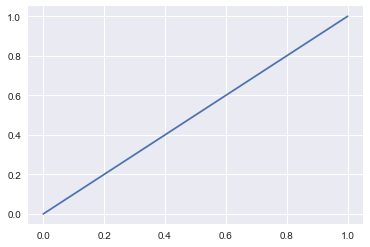

In [20]:
plt.figure()
lw = 2
plt.plot(fpr, tpr)

In [21]:
delta = []

for index in range(0,y_test_df.shape[0]):
    delta.append((grid_classification.predict(X_test_df))[index] -y_test_df.values[index])

In [22]:
(grid_classification.predict(X_test_df))

array([0, 0, 0, ..., 0, 0, 0])

In [23]:
delta


[0,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 

In [24]:
(grid_classification.predict(X_test_df))[0]

0